In [10]:
import os
import sys
import random
import time
from random import seed, randint
import argparse
import platform
from datetime import datetime
import imp
import numpy as np
import fileinput
from itertools import product
import pandas as pd

In [52]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
# plt.rcParams['figure.figsize'] = (10,5) 
# plt.rcParams['figure.figsize'] = (10,5.625)   # 16:9
plt.rcParams['figure.figsize'] = (10,6.180)    #golden ratio
# plt.rcParams['figure.figsize'] = (10*2,6.180*2)    #golden ratio

In [1]:
from Bio.PDB.PDBParser import PDBParser


In [85]:
def read_lammps(lammps_file="dump.lammpstrj", center=False, ca=True):
    nFrame = 0
    with open(lammps_file, "r") as lfile:
        for line in lfile:
            l = line.strip()
            if l[:5]=="ITEM:":
                item = l[6:]
            else:
                if item == "TIMESTEP":
                    step = int(l)
                    try:
                        atoms_all_frames.append(atoms)
                    except NameError:
                        atoms_all_frames = []
                    atoms = []
                    box = []
                    A = []
                    nFrame = nFrame + 1
                elif item == "NUMBER OF ATOMS":
                        n_atoms = int(l)
                        xyz_count = 0
                elif item[:10] == "BOX BOUNDS":
                    # I center x, y not z
                    if center:
                        if xyz_count <= 1:
                            xyz_count += 1
                            box.append(l)
                            l = l.split()
                            # A.append([float(l[0]), float(l[1])])
                            l_left = (float(l[0]) - float(l[1]))/2.0
                            l_right = (float(l[1]) - float(l[0]))/2.0
                            A.append([l_left, l_right])
                            # print l_right - l_left
                        else:
                            xyz_count = 0
                            box.append(l)
                            l = l.split()
                            A.append([float(l[0]), float(l[1])])
                            # l_left = (float(l[0]) - float(l[1]))/2.0
                            # l_right = (float(l[1]) - float(l[0]))/2.0
                            # A.append([l_left, l_right])
                            # print l_right - l_left
                    else:
                        box.append(l)
                        l = l.split()
                        A.append([float(l[0]), float(l[1])])
                elif item[:5] == "ATOMS":
                    l = l.split()
                    i_atom = int(l[0])
                    x = float(l[2])
                    y = float(l[3])
                    z = float(l[4])
                    x = (A[0][1] - A[0][0])*x + A[0][0]
                    y = (A[1][1] - A[1][0])*y + A[1][0]
                    z = (A[2][1] - A[2][0])*z + A[2][0]
                    # C alpha distance
                    if ca:
                        if i_atom % 3 == 1:
                            atom = [x, y, z]
                            atoms.append(atom)
                    else:   # C beta or H in the case of GLY
                        if i_atom % 3 == 0:
                            atom = [x, y, z]
                            atoms.append(atom)
        atoms_all_frames.append(atoms)
    return atoms_all_frames

In [78]:
MAX_OFFSET = 4
DISTANCE_CUTOFF = 9.5
struct_id = '2xov'
filename = "/Users/weilu/Research/server/feb_2018/week_of_feb05/rg_0.1_lipid_1.0_mem_1/simulation/dis_30.0/2xov.pdb"
p = PDBParser(PERMISSIVE=1)
s = p.get_structure(struct_id, filename)
chains = s[0].get_list()

# import pdb file
native_coords = []
for chain in chains:
    dis = []
    all_res = []
    for res in chain:
        is_regular_res = res.has_id('CA') and res.has_id('O')
        res_id = res.get_id()[0]
        if (res.get_resname()=='GLY'):
            native_coords.append(res['CA'].get_coord())
        elif (res_id==' ' or res_id=='H_MSE' or res_id=='H_M3L' or res_id=='H_CAS') and is_regular_res:
            native_coords.append(res['CB'].get_coord())
        else:
            print('ERROR: irregular residue at %s!' % res)
            exit()
native_coords = np.array(native_coords)
a= native_coords[:,np.newaxis]
dis = np.sqrt(np.sum((a - native_coords)**2, axis=2))

n = len(dis)
remove_band = np.eye(n)
for i in range(1, MAX_OFFSET):
    remove_band += np.eye(n, k=i)
    remove_band += np.eye(n, k=-i)
dis[remove_band==1] = np.max(dis)

In [79]:
native_contacts = dis < DISTANCE_CUTOFF

In [81]:
np.sum(native_contacts, axis=1)

array([ 1,  4, 11,  9,  4, 12, 15,  7,  4, 13,  6,  2,  5, 12,  5,  3, 10,
       10,  3,  8, 11,  2,  3,  6,  4,  7,  4,  5, 11, 12,  3,  7, 13, 13,
       16, 10,  8,  2,  0,  2,  6,  3,  2,  5,  2,  3, 11,  7,  9, 11, 16,
       18, 13, 18, 18, 11,  6,  2,  7, 13, 11,  4,  8, 15,  9,  5, 14, 13,
        9,  6, 18, 18, 12, 12, 15, 13,  9,  6, 11,  6,  7,  6, 10, 16,  5,
        4, 16, 13,  5, 10, 20, 16,  6,  9, 21, 17,  6, 11, 16, 11,  3,  4,
        8,  4, 12,  9, 16, 18, 17, 17, 17, 21, 18, 18, 17, 20, 19, 17, 14,
       21, 14, 13, 13, 17, 11,  5,  7,  9,  4,  1,  8,  6, 15,  8, 14,  2,
        1,  2,  8,  5,  3,  3, 12,  3,  2, 11,  7,  4,  8, 10,  5,  2,  3,
        3,  9,  7, 20, 14, 16,  8,  5,  8, 18, 15,  7, 13, 22, 12,  8, 15,
       16,  9,  6, 12, 15,  7,  2, 10,  8,  3,  1])

In [171]:
def compute_native_contacts(coords, MAX_OFFSET=4, DISTANCE_CUTOFF=9.5):
    native_coords = np.array(coords)
    a= native_coords[:,np.newaxis]
    dis = np.sqrt(np.sum((a - native_coords)**2, axis=2))

    n = len(dis)
    remove_band = np.eye(n)
    for i in range(1, MAX_OFFSET):
        remove_band += np.eye(n, k=i)
        remove_band += np.eye(n, k=-i)
    dis[remove_band==1] = np.max(dis)
    native_contacts = dis < DISTANCE_CUTOFF
    return native_contacts.astype("int")

In [202]:
def compute_contacts(coords, native_contacts, DISTANCE_CUTOFF=9.5):
    native_coords = np.array(coords)
    a= native_coords[:,np.newaxis]
    dis = np.sqrt(np.sum((a - native_coords)**2, axis=2))
    constacts = dis < DISTANCE_CUTOFF
    constacts = constacts*native_contacts  #remove non native contacts
    return np.sum(constacts, axis=1).astype("float")

In [188]:
native_contacts_table = compute_native_contacts(native_coords, MAX_OFFSET, DISTANCE_CUTOFF)

In [204]:
native_contacts = compute_contacts(native_coords, native_contacts_table)

In [205]:
native_contacts 

array([  1.,   4.,  11.,   9.,   4.,  12.,  15.,   7.,   4.,  13.,   6.,
         2.,   5.,  12.,   5.,   3.,  10.,  10.,   3.,   8.,  11.,   2.,
         3.,   6.,   4.,   7.,   4.,   5.,  11.,  12.,   3.,   7.,  13.,
        13.,  16.,  10.,   8.,   2.,   0.,   2.,   6.,   3.,   2.,   5.,
         2.,   3.,  11.,   7.,   9.,  11.,  16.,  18.,  13.,  18.,  18.,
        11.,   6.,   2.,   7.,  13.,  11.,   4.,   8.,  15.,   9.,   5.,
        14.,  13.,   9.,   6.,  18.,  18.,  12.,  12.,  15.,  13.,   9.,
         6.,  11.,   6.,   7.,   6.,  10.,  16.,   5.,   4.,  16.,  13.,
         5.,  10.,  20.,  16.,   6.,   9.,  21.,  17.,   6.,  11.,  16.,
        11.,   3.,   4.,   8.,   4.,  12.,   9.,  16.,  18.,  17.,  17.,
        17.,  21.,  18.,  18.,  17.,  20.,  19.,  17.,  14.,  21.,  14.,
        13.,  13.,  17.,  11.,   5.,   7.,   9.,   4.,   1.,   8.,   6.,
        15.,   8.,  14.,   2.,   1.,   2.,   8.,   5.,   3.,   3.,  12.,
         3.,   2.,  11.,   7.,   4.,   8.,  10.,   

In [159]:
dump = read_lammps("/Users/weilu/Research/server/feb_2018/week_of_feb05/rg_0.1_lipid_1.0_mem_1/simulation/dis_32.0/0/dump.lammpstrj.8", ca=False)

In [206]:
localQ_list = []
for atom in dump:
    contacts = compute_contacts(np.array(atom), native_contacts_table, DISTANCE_CUTOFF=DISTANCE_CUTOFF)
    c = np.divide(contacts, native_contacts, out=np.zeros_like(contacts), where=native_contacts!=0)
    localQ_list.append(c)
data = np.array(localQ_list)

In [200]:
contacts = compute_contacts(np.array(dump[0]), native_contacts_table, DISTANCE_CUTOFF=DISTANCE_CUTOFF)

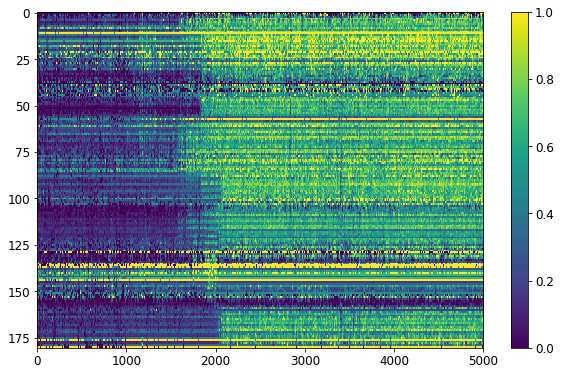

In [210]:
data = np.array(localQ_list)
plt.imshow(data.T, aspect="auto")
plt.colorbar()

In [194]:
np.max(data)

1.0

In [195]:
np.min(data)

0.0

In [164]:
c

array([ 0.        ,  0.25      ,  0.81818182,  0.88888889,  1.25      ,
        0.75      ,  0.86666667,  0.85714286,  1.        ,  0.84615385,
        1.33333333,  1.        ,  1.        ,  1.        ,  1.2       ,
        1.66666667,  0.9       ,  1.        ,  1.33333333,  1.125     ,
        0.90909091,  1.5       ,  1.        ,  0.83333333,  1.25      ,
        1.14285714,  0.5       ,  1.2       ,  1.27272727,  0.58333333,
        1.33333333,  0.71428571,  0.92307692,  0.76923077,  0.875     ,
        0.4       ,  0.75      ,  1.        ,  0.        ,  1.        ,
        1.33333333,  0.33333333,  0.5       ,  1.2       ,  1.5       ,
        0.66666667,  0.72727273,  1.14285714,  0.66666667,  0.90909091,
        0.8125    ,  0.77777778,  1.        ,  0.77777778,  0.83333333,
        0.81818182,  1.        ,  2.5       ,  0.14285714,  0.69230769,
        1.        ,  1.5       ,  0.625     ,  0.66666667,  1.11111111,
        0.8       ,  0.5       ,  0.92307692,  0.88888889,  1.33

In [108]:
c = np.divide(contacts, native_contacts, out=np.zeros_like(contacts), where=native_contacts!=0)

TypeError: No loop matching the specified signature and casting
was found for ufunc true_divide

In [115]:
>>> a = np.array([-1, 0, 1, 2, 3], dtype=float)
>>> b = np.array([ 0, 0, 0, 2, 2], dtype=float)

>>> c = np.divide(a, b, out=np.zeros_like(a), where=b!=0)
>>> print(c)

[ 0.   0.   0.   1.   1.5]


In [120]:
a.shape

(5,)

In [91]:
b.shape

(181, 3)

In [92]:
native_coords.shape

(181, 3)

In [89]:
dump[0]

AttributeError: 'list' object has no attribute 'shape'

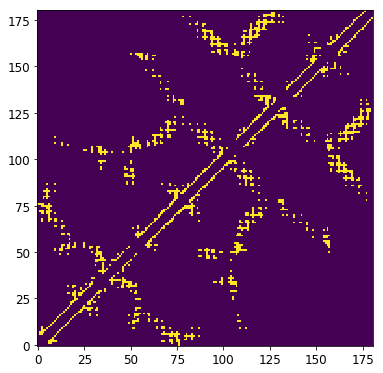

In [75]:
plt.imshow(dis < 9.5, origin='lower')

In [49]:
dis*remove_band

array([[  0.        ,   0.        ,   0.        , ...,  25.01301956,
         29.05464935,  26.2569809 ],
       [  0.        ,   0.        ,   0.        , ...,  27.89468384,
         31.60533905,  28.65100479],
       [  0.        ,   0.        ,   0.        , ...,  25.06340027,
         28.74313927,  26.19666672],
       ..., 
       [ 25.01301956,  27.89468384,  25.06340027, ...,   0.        ,
          0.        ,   0.        ],
       [ 29.05464935,  31.60533905,  28.74313927, ...,   0.        ,
          0.        ,   0.        ],
       [ 26.2569809 ,  28.65100479,  26.19666672, ...,   0.        ,
          0.        ,   0.        ]])

In [43]:
np.eye(5,k=1)

array([[ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.]])

In [22]:
.shape

(181, 1, 3)

In [32]:
dis.shape

(181, 181)

In [25]:
(a - native_coords).shape

(181, 181, 3)

In [29]:
a.shape

(181, 1, 3)

In [17]:
native_coords.shape

(362, 3)

In [ ]:
[:,np.newaxis] - B

In [8]:
native_coords

[array([ 11.06499958,  -0.80199999, -20.29999924], dtype=float32),
 array([ 14.42300034,   1.50899994, -16.1970005 ], dtype=float32),
 array([ 11.23499966,   1.704     , -12.07800007], dtype=float32),
 array([  9.84300041,   5.67600012, -13.94999981], dtype=float32),
 array([ 10.65600014,  10.02000046, -12.19299984], dtype=float32),
 array([ 6.45300007,  8.47000027, -9.31299973], dtype=float32),
 array([  8.15600014,   3.42600012, -10.06200027], dtype=float32),
 array([ 12.98999977,   5.22900009,  -9.58600044], dtype=float32),
 array([ 11.75699997,   9.10700035,  -6.21700001], dtype=float32),
 array([ 8.17500019,  5.43100023, -4.10400009], dtype=float32),
 array([ 12.03899956,   1.82799995,  -4.85699987], dtype=float32),
 array([ 15.45400047,   5.8829999 ,  -3.73200011], dtype=float32),
 array([ 11.94299984,   7.57800007,  -0.31400001], dtype=float32),
 array([ 10.78299999,   2.46700001,   0.99299997], dtype=float32),
 array([ 16.05699921,   1.43700004,   0.221     ], dtype=float32),
 

In [14]:
mu, sigma = 0, 0.001 # mean and standard deviation
X = np.random.normal(mu, sigma, (int(n),2))

In [10]:
s.shape

(1000000, 2)

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, datasets

# import some data to play with
# iris = datasets.load_iris()
# X = iris.data[:, :2]  # we only take the first two features.
# Y = iris.target
n = 1e6
mu, sigma = 0, 100}} # mean and standard deviation
X = np.random.normal(mu, sigma, (int(n),2))

# X = np.random.rand(int(n),2)
# X = np.random.randint(2, size=(100,2))
Y = np.random.randint(2, size=int(n))
h = .02  # step size in the mesh

In [22]:
logreg = linear_model.LogisticRegression(C=1)

# we create an instance of Neighbours Classifier and fit the data.
logreg.fit(X, Y)

# # Plot the decision boundary. For that, we will assign a color to each
# # point in the mesh [x_min, x_max]x[y_min, y_max].
# x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
# y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
# xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# # Put the result into a color plot
# Z = Z.reshape(xx.shape)
# plt.figure(1, figsize=(4, 3))
# plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# # Plot also the training points
# plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
# plt.xlabel('Sepal length')
# plt.ylabel('Sepal width')

# plt.xlim(xx.min(), xx.max())
# plt.ylim(yy.min(), yy.max())
# plt.xticks(())
# plt.yticks(())

plt.show()
logreg.coef_

array([[  9.30496021e-06,   2.02059006e-05]])

In [39]:


logreg = linear_model.LogisticRegression(C=0.001)

# we create an instance of Neighbours Classifier and fit the data.
logreg.fit(X, Y)

# # Plot the decision boundary. For that, we will assign a color to each
# # point in the mesh [x_min, x_max]x[y_min, y_max].
# x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
# y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
# xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# # Put the result into a color plot
# Z = Z.reshape(xx.shape)
# plt.figure(1, figsize=(4, 3))
# plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# # Plot also the training points
# plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
# plt.xlabel('Sepal length')
# plt.ylabel('Sepal width')

# plt.xlim(xx.min(), xx.max())
# plt.ylim(yy.min(), yy.max())
# plt.xticks(())
# plt.yticks(())

# plt.show()
logreg.coef_

array([[ 0.00261729,  0.00699159]])

In [18]:
logreg.coef_

array([[-0.55421509,  1.08626766]])

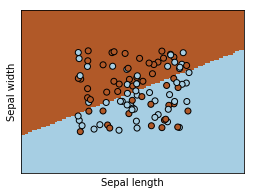

array([[-0.37177846,  0.69021342]])

In [21]:
logreg = linear_model.LogisticRegression(C=1)

# we create an instance of Neighbours Classifier and fit the data.
logreg.fit(X, Y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()
logreg.coef_

In [5]:
X.shape

(150, 2)

In [10]:
Y.shape

(150,)

In [11]:
Y = np.random.randint(2, size=100)

array([0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 1])

In [8]:
X = np.random.rand(100,2) - 0.5

array([[ 0.2307863 , -0.48469222],
       [ 0.40605838, -0.11351738],
       [-0.23503438,  0.11866574],
       [-0.10383742, -0.45509079],
       [ 0.35625542,  0.40691158],
       [-0.05025682, -0.13459328],
       [ 0.14278331,  0.47035423],
       [-0.13149812, -0.05816769],
       [ 0.30448409,  0.1261345 ],
       [ 0.36001408, -0.14128981],
       [ 0.48362139, -0.19231098],
       [ 0.37094612, -0.30143582],
       [-0.17272141,  0.49316   ],
       [ 0.15740091, -0.16811762],
       [ 0.44076051, -0.11703988],
       [-0.00073148, -0.37747617],
       [ 0.21077316, -0.17760818],
       [ 0.2998303 ,  0.12776617],
       [-0.36623186,  0.04595447],
       [ 0.11545453,  0.22159948],
       [-0.12810018, -0.37659821],
       [ 0.43964474, -0.37573036],
       [-0.37568209, -0.33172956],
       [-0.19409524,  0.08899616],
       [ 0.48291882, -0.18241232],
       [ 0.20637445,  0.00142292],
       [ 0.1486748 ,  0.18465496],
       [ 0.41048277, -0.43389116],
       [-0.43529362,

In [2]:
def expand_grid(dictionary):
    return pd.DataFrame([row for row in product(*dictionary.values())],
                        columns=dictionary.keys())

In [3]:

modify_list = {"MY_RG":[0.4],
                "MY_LIPID":[2],
                "MY_RUN":list(range(12))}

In [5]:
data = expand_grid(modify_list)

In [13]:
data

,MY_RG,MY_LIPID,MY_RUN
0,0.4,2,0
1,0.4,2,1
2,0.4,2,2
3,0.4,2,3
4,0.4,2,4
5,0.4,2,5
6,0.4,2,6
7,0.4,2,7
8,0.4,2,8
9,0.4,2,9


In [18]:
data["MY_RG"][9]

0.40000000000000002

In [14]:
for i in data.values:
    print(i)

[ 0.4  2.   0. ]
[ 0.4  2.   1. ]
[ 0.4  2.   2. ]
[ 0.4  2.   3. ]
[ 0.4  2.   4. ]
[ 0.4  2.   5. ]
[ 0.4  2.   6. ]
[ 0.4  2.   7. ]
[ 0.4  2.   8. ]
[ 0.4  2.   9. ]
[  0.4   2.   10. ]
[  0.4   2.   11. ]


In [10]:
def expand_grid2(data_dict):
    """Create a dataframe from every combination of given values."""
    rows = product(*data_dict.values())
    return pd.DataFrame.from_records(rows, columns=data_dict.keys())

In [19]:
d2 = expand_grid2(modify_list)

In [20]:
d2["MY_RG"][9]

0.40000000000000002

In [22]:
for index, row in d2.iterrows():
    print(index, row)

0 MY_RG       0.4
MY_LIPID    2.0
MY_RUN      0.0
Name: 0, dtype: float64
1 MY_RG       0.4
MY_LIPID    2.0
MY_RUN      1.0
Name: 1, dtype: float64
2 MY_RG       0.4
MY_LIPID    2.0
MY_RUN      2.0
Name: 2, dtype: float64
3 MY_RG       0.4
MY_LIPID    2.0
MY_RUN      3.0
Name: 3, dtype: float64
4 MY_RG       0.4
MY_LIPID    2.0
MY_RUN      4.0
Name: 4, dtype: float64
5 MY_RG       0.4
MY_LIPID    2.0
MY_RUN      5.0
Name: 5, dtype: float64
6 MY_RG       0.4
MY_LIPID    2.0
MY_RUN      6.0
Name: 6, dtype: float64
7 MY_RG       0.4
MY_LIPID    2.0
MY_RUN      7.0
Name: 7, dtype: float64
8 MY_RG       0.4
MY_LIPID    2.0
MY_RUN      8.0
Name: 8, dtype: float64
9 MY_RG       0.4
MY_LIPID    2.0
MY_RUN      9.0
Name: 9, dtype: float64
10 MY_RG        0.4
MY_LIPID     2.0
MY_RUN      10.0
Name: 10, dtype: float64
11 MY_RG        0.4
MY_LIPID     2.0
MY_RUN      11.0
Name: 11, dtype: float64


In [24]:
type(list(range(10))[0])

int

In [27]:
for key in d2.keys():
    print(key)

MY_RG
MY_LIPID
MY_RUN
